**NOTE: This is an Incomplete Implementation and there's almost definitely some bugs in the Differentiable Boundary Tree's implementation.**

P.S: This was before PyTorch so the repeated TF graph teardown and building were the only straightforward way I could come up with.

In [236]:
%%javascript
//Widget to add a floating status update window at the bottom of the page
require.undef("updater-widget");
define("updater-widget", ["jquery","jquery-ui","jupyter-js-widgets"], function($,ui,widget){
    var StatusView = widget.DOMWidgetView.extend({
        render: function(){
            this.statusup = document.createElement("div");
            this.statusup.textContent = "Use the python function push_line() to add stuff to this resizable div.";
            this.statusup.style="width:200%;height:150px;position:fixed;bottom:0px;left:0px;background-color:#FFFFFF;z-index:99999999999;border-top:2px solid #000000;overflow:scroll;"
            this.statusup.className = "update_entry"
            this.el.appendChild(this.statusup);
            this.childrencount=0;
        },
        update: function(){
            if( this.childrencount==0){
                $('.update_entry').resizable({
                    handles: 'n'
                });
            }
            var upd = document.createElement('div');
            upd.innerHTML = "<div style='border-bottom:1px solid #EEEEEE'>"+this.model.get("value")+"</div"
            this.statusup.appendChild(upd); 
            this.statusup.scrollTop = this.statusup.scrollHeight;
            if(this.childrencount>150){
                this.statusup.firstChild.remove()
            }
            this.childrencount=this.childrencount+1;
        }
    });
    return {StatusView: StatusView}
})


<IPython.core.display.Javascript object>

In [237]:
from ipywidgets import HTML
from traitlets import Unicode, Int

class UpdaterHTML(HTML):
    _view_module = Unicode("updater-widget").tag(sync=True)
    _view_name = Unicode("StatusView").tag(sync=True)
    value = Unicode().tag(sync=True)
    
def push_line(*args):
    updater.value = " ".join(list(map(str,args)))
    
updater = UpdaterHTML()
updater

In [238]:
push_line("Use the push_line() function to add data to this.")
push_line("Use the push_line() function to add data to this.")


In [239]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [240]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

def sample(data,num_samples,labels=None):
    indices = np.random.choice(len(data),num_samples)
    if labels is not None:
        return (data[indices],labels[indices])
    return data[indices]


#Get the data
data_x,data_y_ori = make_moons(n_samples=1000) 

#Test-train split
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y_ori, test_size=0.33, random_state=42)

#Plot for visualization
fig = plt.figure()
plt.scatter(X_train[y_train==0,0],X_train[y_train==0,1])
plt.scatter(X_train[y_train==1,0],X_train[y_train==1,1])
plt.close(fig)

#Convert into one hot.
y_train = np.eye(2)[y_train]
y_test = np.eye(2)[y_test]

len(y_train),len(y_test)

(670, 330)

## Define the Boundary Tree (Mathy. et al 2015)
We first implement the boundary tree as described in the original paper by Mathy et.al (http://bit.ly/2nllgTS)

In [241]:
#General Utilities

def softmax(x):
    '''A numerically safer softmax'''
    if x.ndim == 1:
        x = x.reshape((1, -1))
    max_x = np.max(x, axis=1).reshape((-1, 1))
    exp_x = np.exp(x - max_x)
    return exp_x / np.sum(exp_x, axis=1).reshape((-1, 1))

def distl2(xs,q):
    '''Computes the L2 Norm between xs and q'''
    return np.linalg.norm(xs-q,axis=1)

In [242]:
class boundary_tree:
    '''
    Boundary tree class that gives the ability to build and query the boundary tree.
    NOTE: This is a base-class without any Neural Network things (With the exception of a dummy "get_representation" function)
    '''
    def __init__(self,k):
        self.k = k
        
    
    def query_tree(self,query_node):
        '''
        BTQUERY(y) from the boundary tree paper. Finds the location of the node in the tree
        That has the minimum distance to the query node and returns it's position along with it's children
        so it can be added.
        
        query_node: query node to be added to the network.
                    NOTE: Expecting it to already be in the embedding space.
        
        '''
        assert len(query_node)==len(self.x_tree_rep[0]),"Query_tree called with query different size from representation"
        
        #Initialize the current node pointers to the root node.
        cur_node,cur_node_children = self.root
        
        while True:
            
            #Grab the children's indices.
            children_indices = [cl[0] for cl in cur_node_children]

            #Add the current node and construct the neighbourhood.
            neighbourhood_indices = children_indices+[cur_node]


            neighbourhood_indices = neighbourhood_indices[:self.k]

            #Grab the embeddings on the neighbourhood.
            neighbourhood_indices = np.array(neighbourhood_indices,dtype=np.int32)


            neighbourhood_rep = self.x_tree_rep[neighbourhood_indices]

            #Find the closest node in the neighbourhood to query
            distances = distl2(neighbourhood_rep,query_node)
            nodemin = np.argmin(distances)
            
            #If the node with the minimum distance in the neighbourhood is the root
            #.. (current node) then we've found our x*. We return it and the children
            
            if neighbourhood_indices[nodemin]==cur_node:
                return cur_node,cur_node_children

            #Iterate through the minimum child
            cur_node,cur_node_children = cur_node_children[nodemin]
    
    def get_representation(self,x):
        ''' Dummy function for vanilla BT. Will overwrite with NN based representation'''
        print("Not in embedding")
        return x
    
    def build_tree(self,data_tree):
        '''
        Build the boundary tree from the samples passed through data_tree.
        data_tree: tuple of xs and ys (inputs and labels)
        '''
        self.x_tree,self.y_tree = data_tree
        
        #Convert datatype to float. The int is to avoid strange rounding errors.
        self.y_tree = np.float32(np.int32(self.y_tree))
        
        #Maintain a mask of samples we used to build the tree. Useful for debugging.
        self.sample_in_tree = np.zeros(len(self.y_tree),dtype=np.bool)
        
        #Precompute the embeddings since batch should be much more effective
        self.x_tree_rep = self.get_representation(self.x_tree)
        
        #The first sample always becomes the root. 
        self.root = (0,[])
        self.sample_in_tree[0] = True
        
        #Iterate through the samples other than the first one.
        #.. xsr = x sample in representation (embedding)
        for sample_index,(xsr,ys) in enumerate(zip(self.x_tree_rep[1:],self.y_tree[1:])):

            #Grab the closest node in the tree. We don't need paths so throw them away
            minnode,minnode_children = self.query_tree(xsr)
            
            #Check it's class prediction. If we were wrong then we have to add it to the current
            #.. node as a child. Argmax because it's onehot.
            if np.argmax(self.y_tree[minnode])!=np.argmax(ys):
                minnode_children.append((sample_index+1,[])) #sample_index+1 because loop starts from second sample.
                self.sample_in_tree [sample_index+1] = True
        
        return self.root

                
    def visualize_graph(self):
        '''
        Construct and return a graph from the tree that we've built.
        Note: Moving the import statements in here. This is *VERY* unpythonic.
        '''
        #NetworkX & nxpd for graph visualization
        import networkx as nx
        from nxpd import draw
        from nxpd import nxpdParams
        nxpdParams['show'] = 'ipynb'
        
        g = nx.DiGraph()

            
        def dfs_draw(curnode_ptr):
            curnode,curnode_children = curnode_ptr
            for child in curnode_children:
                g.add_edge(str(curnode)+"("+str(np.argmax(self.y_tree[curnode]))+")",str(child[0])+"("+str(np.argmax(self.y_tree[child[0]]))+")")
                dfs_draw(child[1])
    
        dfs_draw(self.root)
        
        return g

           
    def predict(self,x):
        '''
        Predict the class of the input x by finding it's representation and querying it's position in the tree
        using the query function and returning the class of the closest match.
        '''
        
        x_rep = self.get_representation(x)
        res = np.array(list(map(lambda xs:self.y_tree[self.query_tree(xs)[0]],x_rep)),dtype=np.int32)
        
        return res
    
    def evaluate(self,data):
        '''
        Calculate the accuracy on the test set based off predictions from the tree.
        '''
        
        x_test, y_test = data
        preds = self.predict(x_test)
        return np.float32(np.count_nonzero(np.argmax(preds,axis=1)==np.argmax(y_test,axis=1)))/len(y_test)
 
    
    def get_percent_nodes_retained(self):
        '''
        Get the percentage of nodes retained after building the tree and return it.
        '''
        return np.float32(np.count_nonzero(self.sample_in_tree))/len(self.y_tree)
    

Add all the Neural Network Goodness and Make the Differentiable Boundary Tree :)
This is from the paper by Zoran et. al. (https://arxiv.org/abs/1702.08833)

In [243]:
def variable_summaries(var):
    """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)
        
def fc_layer(input_tensor, input_dim, output_dim, layer_name,act=tf.nn.relu,dropout_keep_prob = 0.5,existing_weights = None):
    """
    Reusable code for making a simple FC layer.
    if existing_weights is None: Will freshly initialize variable.
    else, existing_weights = (w,b)
    """
    # Adding a name scope ensures logical grouping of the layers in the graph.
    with tf.name_scope(layer_name):
        # This Variable will hold the state of the weights for the layer
        with tf.name_scope('weights'):
            if existing_weights is None:
                weights = tf.get_variable(layer_name+'w', shape=(input_dim, output_dim), initializer=tf.contrib.layers.xavier_initializer()) 
            else:
                weights = tf.Variable(existing_weights[0],name=layer_name+'w')
            variable_summaries(weights)
            
        with tf.name_scope('biases'):
            if existing_weights is None:
                biases = tf.Variable(tf.constant(0.1, shape=[output_dim]),name=layer_name+'b')
            else:
                biases = tf.Variable(existing_weights[1],name=layer_name+'b')
            variable_summaries(biases)
            
        with tf.name_scope('Wx_plus_b'):
            preactivate = tf.matmul(input_tensor, weights) + biases
            tf.summary.histogram('pre_activations', preactivate)
            
        activations = act(preactivate, name='activation')
        tf.summary.histogram('activations', activations)
        
#         with tf.name_scope('dropout'):
#             dropped = tf.nn.dropout(activations, dropout_keep_prob)

        return activations,weights,biases

def create_inference(layer_sizes,num_classes,saved_weights=None,activationfns = tf.nn.tanh):
    '''
    Create the inference part of the network. This is the FC layers up to the representation layer.
    
    Returns a dictionary that saves (pointers to?)  the tensors of the weights and biases so we can save them.
    '''   
    #Placeholder for batch input and label
    x = tf.placeholder(tf.float32, [None, layer_sizes[0]])
    y = tf.placeholder(tf.float32, [None,  num_classes])
    
    #Create a placeholder for the query point which we'll also always pass through the network stacked with the input
#     q = tf.placeholder_with_default(tf.zeros([1,layer_sizes[0]], dtype=tf.float32),[None,layer_sizes[0]])
    q = tf.placeholder(tf.float32,[1,layer_sizes[0]])
    
    weight_tensors = {"input":x,"label":y,"input_q":q}
    
    #Stack the query to the input and pass it through the network
    input_tensor = tf.concat([q,x],axis=0)
    
    for i in range(1,len(layer_sizes)):
        layer_name = "layer"+str(i)
        
        if saved_weights is not None:
            eweights = saved_weights[layer_name]
        else:
            print("Initializing",layer_name," with random init")
            eweights = None

#         keep = 0.5 if i<len(layer_sizes)-1 else 1.0
        acti = activationfns if i<len(layer_sizes)-1 else tf.identity
        input_tensor,w_t,b_t = fc_layer(input_tensor,layer_sizes[i-1],layer_sizes[i],layer_name,
                                        existing_weights = eweights,
                                        act=acti)
        
        weight_tensors[layer_name] = (w_t,b_t)
      
    
    #Split the output into q's representation and everything else we passed
    q_rep,output_rep = tf.split(input_tensor,[1,-1])
    weight_tensors["output_rep"] = output_rep
    weight_tensors["q_rep"] = q_rep
    
    return weight_tensors

def create_loss(preds,labels):
    with tf.name_scope('cross_entropy'):
        varss   = tf.trainable_variables() 
        lossL2 = tf.add_n([ tf.nn.l2_loss(v) for v in varss if 'bias' not in v.name ]) * 0.001
        cross_entropy = tf.reduce_mean(tf.losses.softmax_cross_entropy(labels,logits=preds))+lossL2

    tf.summary.scalar('cross_entropy', cross_entropy)
    return cross_entropy

def create_train(ce,maxnorm=None,lr=1e-4):

    with tf.name_scope('train'):
        optimizer = tf.train.AdamOptimizer(lr)
        if maxnorm is None:
            train_step = optimizer.minimize(ce)
        else:
            # Compute the gradients for a list of variables.
            grads_and_vars = optimizer.compute_gradients(ce)
            # Do whatever you need to the 'gradient' part, for example cap them, etc.
            capped_grads_and_vars = [(tf.clip_by_norm(gv[0],maxnorm,axes=0), gv[1]) for gv in grads_and_vars]
            # Ask the optimizer to apply the capped gradients
            train_step = optimizer.apply_gradients(capped_grads_and_vars)
    return train_step


In [244]:
class diff_boundary_tree(boundary_tree):
    DEBUG = False
    '''
    Create the Differentiable Boundary Tree by using the original functionality and adding the Neural Networks
    to give us the representation and the functionality to train a better representation of it
    '''
    def __init__(self,k,num_classes,layer_sizes,existing_weights=None,lr=1e-4,maxnorm=None):
        '''
        k: Maximum number of children a node can have. Original BT paper parameter
        num_classes: The number of classes for the classification problem
        
        existing_weights: Do we have existing weights for the NN to use? None means init again
        layer_sizes: Structure of nn. List of layers starting from ip-hidden1-hidden2-...-op
        lr: Learning Rate of the Net
        maxnorm: Maxnorm constraint on gradients for regularization. Helpful for relus. Especially during dropout
        '''
        self.k,self.num_classes,self.layer_sizes= k,num_classes,layer_sizes
        self.existing_weights,self.lr,self.maxnorm = existing_weights,lr,maxnorm
        self.rep_size = layer_sizes[-1] #Stores the size of the representation vector for ease of asserts
        
        self.network_destroyed = True
        
        #Initialize the network(with the inference layers) so we can get representation (but not train)
        self.init_network()


    def init_network(self):
        '''
        Create the inference layer and open up an interactive session to interact with the computation
        graph. Also grabs the tensor placeholders so we can pass them values.
        '''
        #weight_t gives us a dict of tensor (pointers) we can use to access weights
        self.weight_t = create_inference(self.layer_sizes,self.num_classes,self.existing_weights)
        
        #Save the input tensor to which we have to pass the raw input
        self.x_t = self.weight_t["input"]
        self.q_t = self.weight_t["input_q"]
        
        #Output tensor which gives us the *representation* (not the final n/w output for loss. That's y_t.
        self.rep_t   = self.weight_t["output_rep"] 
        self.q_rep_t = self.weight_t["q_rep"]
        
        
        self.label_t = self.weight_t['label']
        
        
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
        self.network_destroyed = False
        
    def get_representation(self,x):
        '''
        Overwrite the dummy representation pass of the base class.
        Do a forward pass of the network and get a representation from it.
        '''
        assert type(x) is np.ndarray," get_representation called with a list"
        assert self.network_destroyed == False,"tried to get_represenation after network close"
        
        return self.sess.run(self.rep_t,feed_dict={self.x_t: x.reshape([-1,self.layer_sizes[0]]),
                                                   self.q_t:np.zeros([1,self.layer_sizes[0]])})
    
    def get_weights(self):
        '''
        Get the weights and biases and return them in the form of a dict.
        This is different from weight_t since those are tensors. We want to evaluate them and grab their values.
        '''
        weight_arrays = {}
        for k,v in self.weight_t.items():
            #If it's a tuple of weight and biases.
            #.. because IP,OP and rep are all directly stored and we don't care
            if type(v) is tuple:
                w,b = v
                weight_arrays[k] = (w.eval(),b.eval())
        return weight_arrays
    
    def destroy(self):
        '''
        Destroys the tree and marks the current graph to be destroyed and closes the session.
        Also grabs the weight automatically and returns since this is expected behaviour.
        '''
        weights = self.get_weights()
        
        for k,v in weights.items():
            if type(v) is tuple and not np.isfinite(v[0]).all():
                weights = self.existing_weights
                push_line("*****Found NaNs in weights. Throwing away weight update*****")
                break
        
        tf.reset_default_graph()
        self.sess.close()
        self.network_destroyed=True
        return weights
    
    
    
    def distl2_t(self,x,y):
        '''
        Overflow caution. Deriv of sqrt for tiny,tiny numbers will blow gradients up till inf.
        '''
        return tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(x,y)), 1))
        
    def build_graph(self,sample):
        '''
        Build the computation graph.
        Now, this part's a little counter-intuitive because in order to build the NN graph, we need to 
        know the represenation of the graph. However, we cannot use those representations we've recomputed
        as inputs to graph operations because those will be constants and cut off gradient flow. 
        
        Query point -> WEIGHTS -> Representation1  \
                                                    Distance(Representation1, Representation1) -> Output
        Stored Points-> WEIGHTS -> Representation2 / 
        
        If it's set up like that the gradients of the weights wrt to the output flow through both rep1 and rep2

        Query point -> WEIGHTS -> Representation1   \
                                                     Distance(Representation1, Representation1) -> Output
                           CONSTANT:Representation2 / 
        
        If we do this, the gradients will only flow through rep1 and rep2 will have no contribution.
        
        In order to work-around these two problems, we do the building in parallell with a normal query.
        We begin with the same data, in the form of an array(which is available to us at build time) 
        and a tensor(which will be available during runtime)
        '''

        #Initialize an accumulator for the greedy path probability
        total_greedy_logprob_t = tf.Variable(tf.zeros([1,self.num_classes],dtype=tf.float32),dtype=tf.float32)
        total_greedy_logprob = np.zeros(1,dtype=np.float32)
        
        #Maintain a list of all the indices of the *TREE* that we encounter along the path.
        # .. We'll use this to filter out 
        cur_node,cur_node_children = self.root #Initialize pointers to the root of the eqn.
        
        #Grab the main array of stored data we're going to work off 
        # This is going to be exactly the data we pass the graph (through self.x_t) when we're done building it
        x_kept = self.x_kept
        
        #Get the representation for us to use. Note: Since we also need the representation of sample,
        ##.. We're going to pass it as 'q_t' and get it's rep back
        xkr,qr = self.sess.run([self.rep_t,self.q_rep_t],feed_dict={self.x_t: x_kept.reshape([-1,self.layer_sizes[0]]),
                                                          self.q_t: sample.reshape([1,self.layer_sizes[0]]) })
        qr = qr.reshape([1,-1])
        #We'll use tensors of the result instead of the actual evaluated results
        xkr_t,qr_t = self.rep_t,self.q_rep_t

        # Initialize Variables with None to handle special case of root being closest match
        prev_distances_t = None
        prev_distances = None
        prev_neig_indices = None
        prev_greedy_logprob_t = tf.Variable(tf.zeros([1,self.num_classes],dtype=tf.float32),dtype=tf.float32)
        
        if self.DEBUG: print("New Query")
        while True:
            #Grab the children's indices.
            children_indices = [cl[0] for cl in cur_node_children]

            #Add the current node and construct the neighbourhood.
            neighbourhood_indices = children_indices+[cur_node]
            neighbourhood_indices = np.array(neighbourhood_indices,dtype=np.int32)
            neigh_keep_indices = self.tree_to_kept[neighbourhood_indices]
            
            #Find the nodes that belong to the neighbourhood, both for tree and for the NN.
            neighbourhood_rep = xkr[neigh_keep_indices]
            neighbourhood_rep_t = tf.gather(xkr_t,neigh_keep_indices)
            
            if self.DEBUG:
                print("In the neighbourhood",neighbourhood_indices)
                
            #Find the closest node to the query node
            distances = distl2(neighbourhood_rep,qr)
        
            #Now, we need to know if we reached the final node or not. The operation we do on the computation
            #.. Graph changes based on that. 
            nodemin = np.argmin(distances[:self.k])
            if neighbourhood_indices[nodemin]!=cur_node:
                #We can go further down. We do that and accumulate greedy probability in log-scale

                if self.DEBUG:
                    print("Found next loop Can go futher down")
                    print("distances:",distances)
                    logprob = softmax(-distances)
                    print ("Logprobs",logprob)
                    prev_distances = distances[:-1]
                    total_greedy_logprob+=np.max(distances)
                    print("Greedy Logprob and total logprob:",np.max(distances),total_greedy_logprob)

                distances_t = tf.reshape(self.distl2_t(neighbourhood_rep_t,qr_t),[1,len(neighbourhood_indices)])
                logprob_t = tf.nn.log_softmax(tf.negative(distances_t)) #log_softmax handles underflow of log(softmax(...))
                greedy_logprob_t = tf.reduce_max(logprob_t)
                
                #NOTE: ADDING PREVIOUS CALCULATED GREEDY LOGPROB AND SAVING THIS ONE
                total_greedy_logprob_t = tf.add(total_greedy_logprob_t,prev_greedy_logprob_t)
                prev_greedy_logprob_t = greedy_logprob_t
                
                #Save the labels and distance tensor of the layer so we can use it when we hit x* 
                prev_distances_t = distances_t  
                prev_neig_indices = neighbourhood_indices
                
                #Take a step down for the next iteration
                cur_node,cur_node_children = cur_node_children[nodemin]
                
            else:        
                           
                #We've reached x*. We need backtrack and find neighbourhood class predictions

                if prev_distances_t==None:
                    '''
                    The closest match was the root. We'll pretend like there was a pseudo root above the root
                    we backtracked to.
                    '''

                    sibling_indices = [0]                    
                    
                    root_rep_t=tf.gather(xkr_t,[0])
                    distances_siblings_t = tf.reshape(self.distl2_t(root_rep_t,qr_t),[1,1])
                    
                    sibling_distances = distl2(xkr[0],qr)

                    push_line("Ping.")
                    
                else:
                    sibling_distances = distances[:-1]
                    sibling_indices = np.array(prev_neig_indices[:-1],dtype=np.int32)#Strip out the root to get sibling indices
                    #We've now backtracked but distances_t also includes the distance of query node
                    #.. to parent(x*) i.e the self edge transition. We need to rip that out.
                    distances_siblings_t,_ = tf.split(prev_distances_t,[-1,1],axis=1) #Since we added cur_node to the end of indices
    #                 distances_siblings_t = prev_distances_t


    
                if self.DEBUG:
                    sibling_distances = prev_distances
                    print("Cannot go futher down. Self loop to",cur_node)
                    print("Backtracking to ",prev_neig_indices)
                    print("with prevdistances",prev_distances)
                    print("Sibling indices",sibling_indices)
                    print("Sibling distances",sibling_distances)
                
                    classprobs=softmax(-sibling_distances).reshape([1,-1])
                    classlabels = self.y_tree[sibling_indices]
                    neigh_classpred = np.matmul(classprobs,classlabels)
                    print("Class probs:",neigh_classpred)
                    pred_t = np.log(neigh_classpred+1e-10)+total_greedy_logprob
                    print("Final Pred",softmax(np.exp(pred_t)-1e-10))
                    



        
                classprobs_t = tf.nn.softmax(tf.negative(distances_siblings_t))
                classlabels_t = tf.constant(self.y_tree[sibling_indices].reshape(-1,self.num_classes),dtype=tf.float32)
                
                #Sum up the labels weighted by their class predictions.
                neigh_classpred_t = tf.matmul(classprobs_t,classlabels_t)
                logneigh_classpred_t = tf.log(tf.maximum(neigh_classpred_t,1e-10)) #1e-10 to handle infs.
                
                #Sum up the accumulated greedy path logprob and the log total neighbourhood predictions
                pred_t = tf.add(logneigh_classpred_t,total_greedy_logprob_t)
                
                #Exponent out and softmax to normalize to classpreds
                final_classpred_t = tf.nn.softmax(tf.exp(pred_t))

                return final_classpred_t
            
            
    def train_tree(self,data):
        '''
        Iterates through the dataset and constructs one graph for every single sample doing one gradient update
        '''
        
        global train_epoch #Maintain a global counter
        
        train_x,train_y = data
        
        losses = []
        
        #First, we'll grab only those samples that form the tree.
        self.sample_indices_kept = np.nonzero(self.sample_in_tree)[0]
        
        #Create a reverse lookup table that'll help up look up the index in the above list 
        #.. given a sample index from the tree
        self.tree_to_kept = np.zeros(len(self.y_tree),dtype=np.int32)+9999 #The 9999 is to throw an error incase something goes wrong
        self.tree_to_kept[self.sample_indices_kept] = list(range(len(self.sample_indices_kept)))
        
        self.x_kept = self.x_tree[self.sample_indices_kept]

        #Go through the samples one by one
        for xs,ys in zip(train_x,train_y):
            
            xs = np.reshape(xs,[1,-1])
            ys = np.reshape(ys,[1,-1])
            #Get the prediction tensor from the graph we've built.
            pred_t = self.build_graph(xs)
            #Attach the loss function to the graph using the xentropy b/w the prediction and the class label tensor
            ce_t = create_loss(pred_t,self.label_t)
            #Create a train step operation out of the loss.
            train_op = create_train(ce_t,maxnorm=self.maxnorm,lr=self.lr)
            #Initialize all the variables we've defined in the computation graph building stage
            self.sess.run(tf.global_variables_initializer())   
            #Now, do the actual forward-backward pass of the neural network we've built up to this point
            _,loss,pred = self.sess.run([train_op,ce_t,pred_t],feed_dict={ 
                    self.x_t : self.x_kept.reshape([-1,self.layer_sizes[0]]),
                    self.q_t : xs,
                    self.label_t : ys
                })
            
            
            losses+=[loss]
            
            push_line("E",train_epoch,"Loss:",loss,"Pred", pred.round(3), "Target:",ys)
            
            train_epoch+=1

            if np.isinf(loss) or np.isnan(loss):
                print ("DEAD FISH.")
                input()
                

                
            #Destroy and reset the computation graph but get it's weights so we can re-init a new one with it
            self.existing_weights = self.destroy()
            
            _ = self.init_network()
            
        return losses
            
              

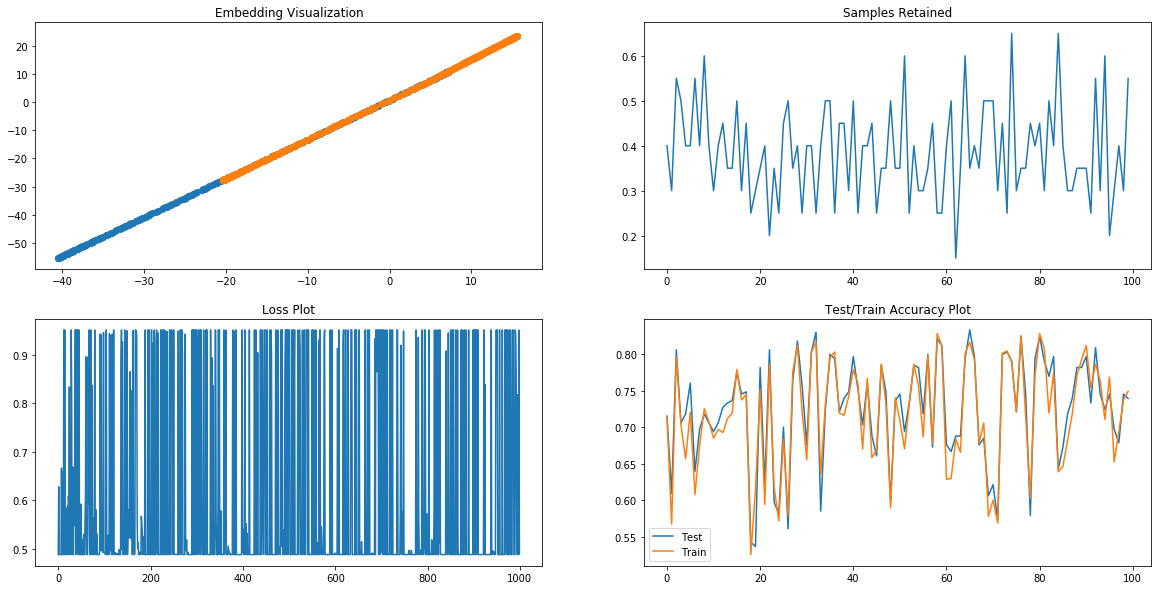

In [234]:
from IPython.display import clear_output

#Tree building params
num_iterations = 1000
num_tree_samples = 20
num_train_samples = 10
layer_sizes = [2,100,100,30,2]
k = 4
num_classes = 2
existing_weights = None #Resets any stored weights.
tf.reset_default_graph()

train_epoch = 0
losses,test_accuracy,train_accuracy,samples_retained = [],[],[],[]

diff_boundary_tree.DEBUG = False
for it in range(num_iterations):
    #Create a new boundary tree
    bt = diff_boundary_tree(k=k,num_classes=num_classes,layer_sizes=layer_sizes,existing_weights = existing_weights,lr=1e-4,maxnorm=None)
    
    #Get a random subset from the training set. Getting combined so both don't overlap.
    x_cut,y_cut = sample(X_train,num_tree_samples+num_train_samples,labels=y_train)
    
    x_tree,xts = x_cut[:num_tree_samples],x_cut[num_tree_samples:]
    y_tree,yts = y_cut[:num_tree_samples],y_cut[num_tree_samples:]

    #Build the tree using the training set.
    root = bt.build_tree((x_tree,y_tree))

    #Sample another batch from the training data and train the NN based off the tree we built.
    loss = bt.train_tree((xts,yts))    
    test_accuracy+=[bt.evaluate((X_test,y_test))]
    train_accuracy+=[bt.evaluate((X_train,y_train))]
    push_line("Test Accuracy",test_accuracy[-1], "Train Accuracy:",train_accuracy[-1])

        
    #Begin Visualization stuff!
    losses+=loss
    samples_retained+=[bt.get_percent_nodes_retained()]
    
    fig = plt.figure(figsize=(20,10))
    ax1 = fig.add_subplot(221)
    ax1.title.set_text("Embedding Visualization")
    
    preds = bt.get_representation(X_train)
    plt.scatter(preds[y_train[:,0]==0,0],preds[y_train[:,0]==0,1])
    plt.scatter(preds[y_train[:,0]==1,0],preds[y_train[:,0]==1,1])
    
    ax2 = fig.add_subplot(222)
    ax2.title.set_text("Samples Retained")
    ax2.plot(samples_retained)
    
    ax3 = fig.add_subplot(223)
    ax3.title.set_text("Loss Plot")
    ax3.plot(losses)
    
    ax4 = fig.add_subplot(224)
    ax4.title.set_text("Test/Train Accuracy Plot")
    ax4.plot(test_accuracy,label="Test")
    ax4.plot(train_accuracy,label="Train")
    ax4.legend()
    
    plt.show()
    plt.close(fig)
    
    clear_output(True)
    existing_weights = bt.destroy()